In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
%matplotlib inline
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import plot_confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install wget
import wget
    
link_to_data = 'https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/training_attack_types.txt?raw=true'
DataSet = wget.download(link_to_data) 

100% [..............................................................] 500 / 500

In [3]:
DataSet

'training_attack_types (36).txt'

In [4]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 
                'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 
                'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 
                'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 
                'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
                'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
                'dst_host_same_src_port_rate', 
                'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
                'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']


# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [5]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open(DataSet, 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

In [6]:
attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'mailbomb': 'dos',
 'processtable': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'smurf': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'udpstorm': 'dos',
 'ps': 'u2r',
 'buffer_overflow': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'loadmodule': 'u2r',
 'xterm': 'u2r',
 'sqlattack': 'u2r',
 'httptunnel': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'snmpguess': 'r2l',
 'imap': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'named': 'r2l',
 'sendmail': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'worm': 'probe',
 'nmap': 'probe',
 'ipsweep': 'probe',
 'portsweep': 'probe',
 'satan': 'probe',
 'mscan': 'probe',
 'saint': 'probe'}

In [7]:
#Processing Training Data

train_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTrain%2B.txt'

train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)

In [8]:
#Processing test Data
test_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTest%2B.txt'

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

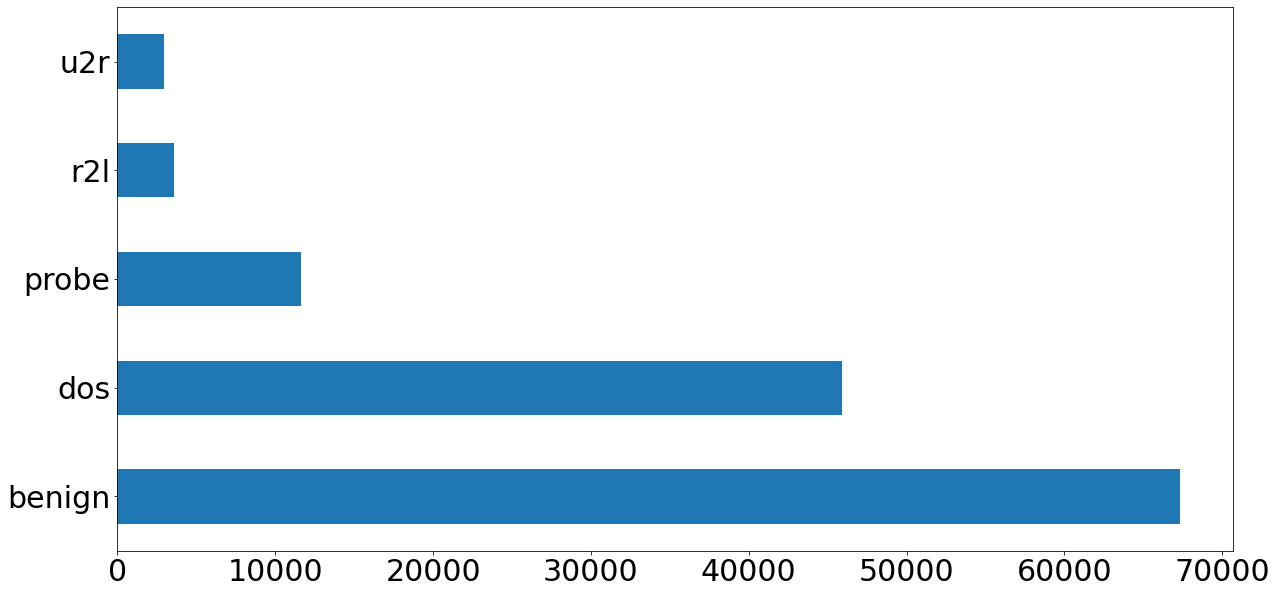

In [9]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

train_df[binary_cols].describe().transpose()
train_df.groupby(['su_attempted']).size()
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()
train_df.groupby(['num_outbound_cmds']).size()

#Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')



#Data Preparation

train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)


combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

#execute the commands in console
train_x.describe()
train_x['duration'].describe()
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Experimenting with MaxAbsScaler on the single 'duration' feature
from sklearn.preprocessing import MaxAbsScaler

max_Abs_scaler = MaxAbsScaler().fit(durations)
robust_scaled_durations = max_Abs_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])
    
train_x.describe()



train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

In [10]:
#4.1 Identifing attributes name(Header)
print(train_df.head)

<bound method NDFrame.head of         duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0              0           tcp  ftp_data   SF        491          0     0   
1              0           udp     other   SF        146          0     0   
2              0           tcp   private   S0          0          0     0   
3              0           tcp      http   SF        232       8153     0   
4              0           tcp      http   SF        199        420     0   
...          ...           ...       ...  ...        ...        ...   ...   
125968         0           tcp   private   S0          0          0     0   
125969         8           udp   private   SF        105        145     0   
125970         0           tcp      smtp   SF       2231        384     0   
125971         0           tcp    klogin   S0          0          0     0   
125972         0           tcp  ftp_data   SF        151          0     0   

        wrong_fragment  urgent  hot  ...  dst

In [11]:
#4.1 Identifing attributes name(Header)
print(test_df.head)

<bound method NDFrame.head of        duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0             0           tcp   private   REJ          0          0     0   
1             0           tcp   private   REJ          0          0     0   
2             2           tcp  ftp_data    SF      12983          0     0   
3             0          icmp     eco_i    SF         20          0     0   
4             1           tcp    telnet  RSTO          0         15     0   
...         ...           ...       ...   ...        ...        ...   ...   
22539         0           tcp      smtp    SF        794        333     0   
22540         0           tcp      http    SF        317        938     0   
22541         0           tcp      http    SF      54540       8314     0   
22542         0           udp  domain_u    SF         42         42     0   
22543         0           tcp    sunrpc   REJ          0          0     0   

       wrong_fragment  urgent  hot  ...  dst_

In [12]:
#4.2 check the length of the train dataset
print(len(train_df))


125973


In [13]:
#4.2 check the length of the test dataset
print(len(test_df))

22544


In [14]:
#4.3 Total Number of Samples that belong to each Five classes of the Training Dataset
train_attack_category = train_df['attack_category'].value_counts()
train_attack_category

benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: attack_category, dtype: int64

In [15]:
#4.3 Total Number of Samples that belong to each Five classes of the Testing  Dataset
test_attack_category = test_df['attack_category'].value_counts()
test_attack_category

benign    9711
dos       7636
r2l       2574
probe     2423
u2r        200
Name: attack_category, dtype: int64

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.2min finished


{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'auto', 'C': 10}
[[8986   92  627    2    4]
 [1557 6062   17    0    0]
 [ 506   93 1819    5    0]
 [2527    2    1   43    1]
 [ 182    3    0    3   12]]
Accuracy for each class:  [0.75616572 0.92175302 0.94459723 0.88728708 0.99143896]
Recall for each class:  [0.9253424  0.79387114 0.75072225 0.01670552 0.06      ]
Precision for each class:  [0.65314726 0.96960972 0.73823052 0.81132075 0.70588235]
False Postive Rate for each class: [3.71853814e-01 1.27448350e-02 3.20560608e-02 5.00751127e-04
 2.23773720e-04]
              precision    recall  f1-score   support

      normal     0.6531    0.9253    0.7658      9711
         dos     0.9696    0.7939    0.8730      7636
       probe     0.7382    0.7507    0.7444      2423
         r2l     0.8113    0.0167    0.0327      2574
         u2r     0.7059    0.0600    0.1106       200

    accuracy                         0.7506     22544
   macro avg     0.7756    0.5093    0.5053     2

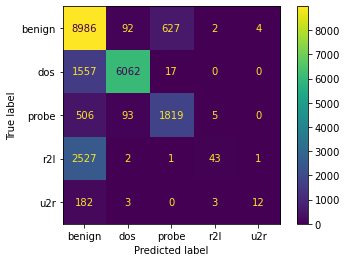

Accuracy Score: 0.7506210078069553
Precision Score: 0.7880101819048121
Recall Score: 0.7506210078069553
F1 Score: 0.7102857037019016
Total Duration: 103.79294943809509 Seconds


In [17]:
#6. classification algorthims
#6.1 Logistic Regression Model
start=time.time()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
#fitting data


model= LogisticRegression()
solvers = ['lbfgs','newton_cg']
penalty =['l2']
c_values = [10,1,0.1]
multi_class =['auto']
ran_cv= dict(solver=solvers,penalty=penalty,C=c_values,multi_class=multi_class)
clf= RandomizedSearchCV(estimator=model, param_distributions=ran_cv, n_jobs=-1, cv=3,n_iter=10,verbose=2,
                               random_state=1)
clf.fit(train_x,train_Y)

print(clf.best_params_)

best_random_cv=clf.best_estimator_
pred_y=best_random_cv.predict(test_x)


conf_mx=confusion_matrix(test_Y, pred_y)
print(conf_mx)


#Performance Measures
FP = conf_mx.sum(axis=0) - np.diag(conf_mx) 
FN = conf_mx.sum(axis=1) - np.diag(conf_mx)
TP = np.diag(conf_mx)
TN = conf_mx.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

#Accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy for each class: ',ACC)

#Recall
TPR = TP/(TP+FN)
print('Recall for each class: ',TPR)

# Precision 
PPV = TP/(TP+FP)
print('Precision for each class: ',PPV)

# False positive rate
FPR = FP/(FP+TN)
print('False Postive Rate for each class:',FPR)

#Classification Report
target_names = ["normal","dos","probe","r2l","u2r"]
print(classification_report(test_Y, pred_y,target_names=target_names,digits=4))

#Multilabel confusion Matrix
print(multilabel_confusion_matrix(test_Y, pred_y,labels=target_names))

#Plot Confusion Matrix
plot_confusion_matrix(clf, test_x, test_Y)  
plt.show()  

#Overall Performance Measures for Algorithm
print('Accuracy Score:',accuracy_score(pred_y, test_Y))
print('Precision Score:',precision_score(test_Y,pred_y,average='weighted'))
print('Recall Score:',recall_score(test_Y,pred_y,average='weighted'))
print('F1 Score:', f1_score(test_Y,pred_y,average='weighted'))


end=time.time()
process_time = end-start
print('Total Duration:',process_time,'Seconds')

[[9374   59  275    2    1]
 [1565 6035   36    0    0]
 [ 672  174 1577    0    0]
 [2307    0    5  261    1]
 [ 180    0    0    7   13]]
Accuracy for each class:  [0.77550568 0.91864798 0.94845635 0.89700142 0.99161639]
Recall for each class:  [0.96529709 0.79033525 0.65084606 0.1013986  0.065     ]
Precision for each class:  [0.66491701 0.96282706 0.8330692  0.96666667 0.86666667]
False Postive Rate for each class: [3.68113457e-01 1.56291924e-02 1.57049848e-02 4.50676014e-04
 8.95094880e-05]
              precision    recall  f1-score   support

      normal     0.6649    0.9653    0.7874      9711
         dos     0.9628    0.7903    0.8681      7636
       probe     0.8331    0.6508    0.7308      2423
         r2l     0.9667    0.1014    0.1835      2574
         u2r     0.8667    0.0650    0.1209       200

    accuracy                         0.7656     22544
   macro avg     0.8588    0.5146    0.5382     22544
weighted avg     0.8201    0.7656    0.7338     22544

[[[22544 

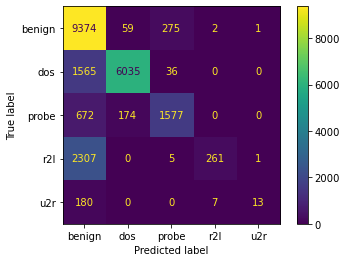

Accuracy Score: 0.7656139105748758
Precision Score: 0.8201391281631827
Recall Score: 0.7656139105748758
F1 Score: 0.7338016885084695
Total Duration: 271.1229956150055 Seconds


In [21]:
##SVM-SVC Model
start=time.time()

from sklearn.svm import SVC 

#fitting data
clf = SVC(kernel='rbf',C=20, gamma='auto',random_state=1)

#Predicting model
pred_y = clf.fit(train_x,train_Y).predict(test_x)
clf.fit(train_x,train_Y)


conf_mx=confusion_matrix(test_Y, pred_y)
print(conf_mx)

#Performance Measures
FP = conf_mx.sum(axis=0) - np.diag(conf_mx) 
FN = conf_mx.sum(axis=1) - np.diag(conf_mx)
TP = np.diag(conf_mx)
TN = conf_mx.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

#Accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy for each class: ',ACC)

#Recall
TPR = TP/(TP+FN)
print('Recall for each class: ',TPR)

# Precision 
PPV = TP/(TP+FP)
print('Precision for each class: ',PPV)

# False positive rate
FPR = FP/(FP+TN)
print('False Postive Rate for each class:',FPR)

#Classification Report
target_names = ["normal","dos","probe","r2l","u2r"]
print(classification_report(test_Y, pred_y,target_names=target_names,digits=4))

#Multilabel confusion Matrix
print(multilabel_confusion_matrix(test_Y, pred_y,labels=target_names))

#Plot Confusion Matrix
plot_confusion_matrix(clf, test_x, test_Y)  
plt.show()  

#Overall Performance Measures for Algorithm
print('Accuracy Score:',accuracy_score(pred_y, test_Y))
print('Precision Score:',precision_score(test_Y,pred_y,average='weighted'))
print('Recall Score:',recall_score(test_Y,pred_y,average='weighted'))
print('F1 Score:', f1_score(test_Y,pred_y,average='weighted'))


end=time.time()
process_time = end-start
print('Total Duration:',process_time,'Seconds')

[[9448   61  202    0    0]
 [1354 6190   92    0    0]
 [ 864  197 1362    0    0]
 [2186    1  387    0    0]
 [ 178   13    9    0    0]]
Accuracy for each class:  [0.78508694 0.92379347 0.92232967 0.88582328 0.99112846]
Recall for each class:  [0.97291731 0.81063384 0.56211308 0.         0.        ]
Precision for each class:  [0.67341411 0.95790777 0.66374269        nan        nan]
False Postive Rate for each class: [0.35704824 0.01824524 0.03429253 0.         0.        ]
              precision    recall  f1-score   support

      normal     0.6734    0.9729    0.7959      9711
         dos     0.9579    0.8106    0.8781      7636
       probe     0.6637    0.5621    0.6087      2423
         r2l     0.0000    0.0000    0.0000      2574
         u2r     0.0000    0.0000    0.0000       200

    accuracy                         0.7541     22544
   macro avg     0.4590    0.4691    0.4566     22544
weighted avg     0.6859    0.7541    0.7057     22544

[[[22544     0]
  [    0     0

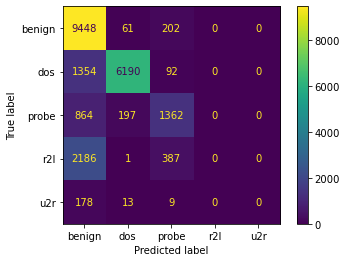

Accuracy Score: 0.7540809084457062
Precision Score: 0.6858745877321867
Recall Score: 0.7540809084457062
F1 Score: 0.7057127880694016
Total Duration: 51.230877161026 Seconds


In [22]:
#6.3 Neural Network - MLPClassifier
start=time.time()
from sklearn.neural_network import MLPClassifier


#fitting data
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5, 
                    #hidden_layer_sizes=(5, 2),random_state=1)

                              
clf=MLPClassifier(hidden_layer_sizes=(5,2), activation='relu', solver='lbfgs',alpha=0.0001,
                  batch_size='auto', learning_rate='constant', 
                  learning_rate_init=0.001,  max_iter=100,
                  shuffle=True, random_state=None)
#Predicting model
pred_y = clf.fit(train_x,train_Y).predict(test_x)


conf_mx=confusion_matrix(test_Y, pred_y)
print(conf_mx)

#Performance Measures
FP = conf_mx.sum(axis=0) - np.diag(conf_mx) 
FN = conf_mx.sum(axis=1) - np.diag(conf_mx)
TP = np.diag(conf_mx)
TN = conf_mx.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

#Accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy for each class: ',ACC)

#Recall
TPR = TP/(TP+FN)
print('Recall for each class: ',TPR)

# Precision 
PPV = TP/(TP+FP)
print('Precision for each class: ',PPV)

# False positive rate
FPR = FP/(FP+TN)
print('False Postive Rate for each class:',FPR)

#Classification Report
target_names = ["normal","dos","probe","r2l","u2r"]
print(classification_report(test_Y, pred_y,target_names=target_names,digits=4))

#Multilabel confusion Matrix
print(multilabel_confusion_matrix(test_Y, pred_y,labels=target_names))

#Plot Confusion Matrix
plot_confusion_matrix(clf, test_x, test_Y)  
plt.show()  

#Overall Performance Measures for Algorithm
print('Accuracy Score:',accuracy_score(pred_y, test_Y))
print('Precision Score:',precision_score(test_Y,pred_y,average='weighted'))
print('Recall Score:',recall_score(test_Y,pred_y,average='weighted'))
print('F1 Score:', f1_score(test_Y,pred_y,average='weighted'))


end=time.time()
process_time = end-start
print('Total Duration:',process_time,'Seconds')

{'n_estimators': [10, 100, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 10, 10], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3], 'criterion': ['entropy', 'gini']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 29.5min finished


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}
RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 10, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 100, 200]},
                   random_state=1, verbose=2)
[[9458   67  186    0    0]
 [1898 5673   65    0    0]
 [ 829  163 1431    0    0]
 [2571    0    0    3    0]
 [ 194    0    5    0    1]]
Accuracy for each class:  [0.74516501 0.90272356 0.94464159 0.88595635 0

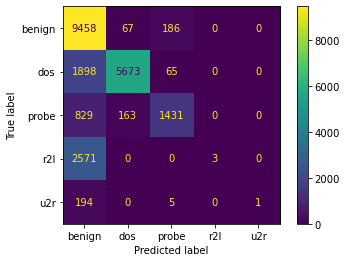

Accuracy Score: 0.7348296664300923
Precision Score: 0.8122505994708311
Recall Score: 0.7348296664300923
F1 Score: 0.6894572059116927
Total Duration: 1867.4451248645782 Seconds


In [23]:
#RandomForest Classifier using RandomizedSearchCV 
start=time.time()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_est = [10,100,200]
# Number of features to consider at every split
max_fe = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_dep = [10, 10, 10]
#Minimum number of samples required to split a node
min_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_leaf = [1, 2, 3]
#Create the random grid
random_forest = {'n_estimators': n_est,
                  'max_features': max_fe,
                   'max_depth': max_dep,
                   'min_samples_split': min_split,
                   'min_samples_leaf': min_leaf,
                  'criterion':['entropy','gini']}
print(random_forest)


rfc=RandomForestClassifier()
randomcv=RandomizedSearchCV(estimator=rfc ,param_distributions=random_forest,
                               cv=3,n_iter=100,verbose=2,
                               random_state=1,n_jobs=-1)
### fit the randomized model
randomcv.fit(train_x,train_Y)

print(randomcv.best_params_)

print(randomcv)

best_random_forest=randomcv.best_estimator_
pred_y=best_random_forest.predict(test_x)


conf_mx=confusion_matrix(test_Y, pred_y)
print(conf_mx)

#Performance Measures
FP = conf_mx.sum(axis=0) - np.diag(conf_mx) 
FN = conf_mx.sum(axis=1) - np.diag(conf_mx)
TP = np.diag(conf_mx)
TN = conf_mx.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

#Accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy for each class: ',ACC)

#Recall
TPR = TP/(TP+FN)
print('Recall for each class: ',TPR)

# Precision 
PPV = TP/(TP+FP)
print('Precision for each class: ',PPV)

# False positive rate
FPR = FP/(FP+TN)
print('False Postive Rate for each class:',FPR)

#Classification Report
target_names = ["normal","dos","probe","r2l","u2r"]
print(classification_report(test_Y, pred_y,target_names=target_names,digits=4))

#Multilabel confusion Matrix
print(multilabel_confusion_matrix(test_Y, pred_y,labels=target_names))

#Plot Confusion Matrix
plot_confusion_matrix(randomcv, test_x, test_Y)
plt.show()  

#Overall Performance Measures for Algorithm
print('Accuracy Score:',accuracy_score(pred_y, test_Y))
print('Precision Score:',precision_score(test_Y,pred_y,average='weighted'))
print('Recall Score:',recall_score(test_Y,pred_y,average='weighted'))
print('F1 Score:', f1_score(test_Y,pred_y,average='weighted'))


end=time.time()
process_time = end-start
print('Total Duration:',process_time,'Seconds')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 28.6min finished


{'n_estimators': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy'}
RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 10, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 100, 200]},
                   random_state=1, verbose=2)
[[9456   61  194    0    0]
 [1984 5579   73    0    0]
 [ 571  221 1631    0    0]
 [2562    0   12    0    0]
 [ 122    0   78    0    0]]
Accuracy for each class:  [0.75629879 0.89624734 0.949033   0.88582328 0.991

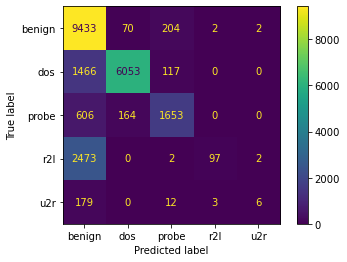

Accuracy Score: 0.7392654364797729
Precision Score: 0.6877818995498278
Recall Score: 0.7392654364797729
F1 Score: 0.6932892694264822
Total Duration: 1797.3299107551575 Seconds


In [28]:
#ExtratreesClassifier
start=time.time()

from sklearn.ensemble import ExtraTreesClassifier

etc=ExtraTreesClassifier(n_estimators=100,criterion='gini',
                             max_features='auto',min_samples_leaf=1,random_state=0,min_samples_split=2)

pred_y = etc.fit(train_x,train_Y).predict(test_x)

randomcv.fit(train_x,train_Y)

print(randomcv.best_params_)

print(randomcv)

best_random_forest=randomcv.best_estimator_
pred_y=best_random_forest.predict(test_x)


conf_mx=confusion_matrix(test_Y, pred_y)
print(conf_mx)

#Performance Measures
FP = conf_mx.sum(axis=0) - np.diag(conf_mx) 
FN = conf_mx.sum(axis=1) - np.diag(conf_mx)
TP = np.diag(conf_mx)
TN = conf_mx.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

#Accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy for each class: ',ACC)

#Recall
TPR = TP/(TP+FN)
print('Recall for each class: ',TPR)

# Precision 
PPV = TP/(TP+FP)
print('Precision for each class: ',PPV)

# False positive rate
FPR = FP/(FP+TN)
print('False Postive Rate for each class:',FPR)

#Classification Report
target_names = ["normal","dos","probe","r2l","u2r"]
print(classification_report(test_Y, pred_y,target_names=target_names,digits=4))

#Multilabel confusion Matrix
print(multilabel_confusion_matrix(test_Y, pred_y,labels=target_names))

#Plot Confusion Matrix
plot_confusion_matrix(etc, test_x, test_Y)
plt.show()  

#Overall Performance Measures for Algorithm
print('Accuracy Score:',accuracy_score(pred_y, test_Y))
print('Precision Score:',precision_score(test_Y,pred_y,average='weighted'))
print('Recall Score:',recall_score(test_Y,pred_y,average='weighted'))
print('F1 Score:', f1_score(test_Y,pred_y,average='weighted'))


end=time.time()
process_time = end-start
print('Total Duration:',process_time,'Seconds')

Text(0.5, 1.0, 'Algorithm Accuracy Bar chart')

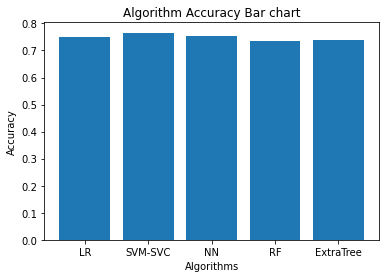

In [29]:
#Bar Chart
algorithms=['LR','SVM-SVC','NN','RF','ExtraTree']
accuracy=[0.7506, 0.7656,0.7541,0.7348,0.7393]

ypos=np.arange(len(algorithms))
plt.xticks(ypos,algorithms)
plt.bar(ypos,accuracy,label='Accuracy')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Algorithm Accuracy Bar chart')

Text(0.5, 1.0, 'Precision Bar chart')

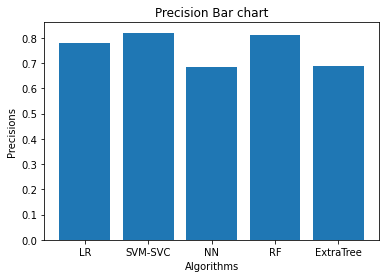

In [30]:
#Bar Chart
algorithms=['LR','SVM-SVC','NN','RF','ExtraTree']
precision=[0.7808, 0.8201,0.6859,0.8123,0.6878]

ypos=np.arange(len(algorithms))
plt.xticks(ypos,algorithms)
plt.bar(ypos,precision,label='Precisions')
plt.xlabel('Algorithms')
plt.ylabel('Precisions')
plt.title('Precision Bar chart')

Text(0.5, 1.0, 'Recall Bar chart')

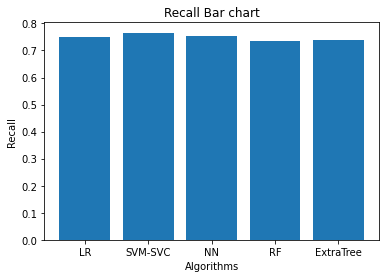

In [31]:
#Bar Chart
algorithms=['LR','SVM-SVC','NN','RF','ExtraTree']
recall=[0.7506, 0.7656,0.7541,0.7348,0.7393]

ypos=np.arange(len(algorithms))
plt.xticks(ypos,algorithms)
plt.bar(ypos,recall,label='Recall')
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.title('Recall Bar chart')

Text(0.5, 1.0, 'F1_score Bar chart')

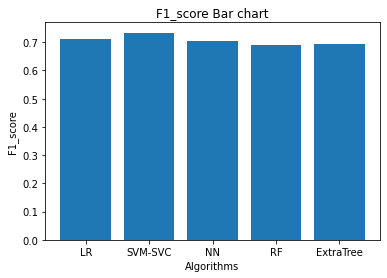

In [33]:
#Bar Chart
algorithms=['LR','SVM-SVC','NN','RF','ExtraTree']
f1_score=[0.7103, 0.7338,0.7057,0.6895,0.6933]

ypos=np.arange(len(algorithms))
plt.xticks(ypos,algorithms)
plt.bar(ypos,f1_score,label='F1_score')
plt.xlabel('Algorithms')
plt.ylabel('F1_score')
plt.title('F1_score Bar chart')

Text(0.5, 1.0, 'Time taken for algorithms Bar chart')

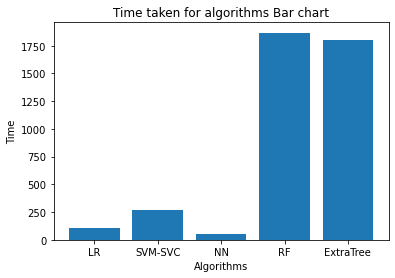

In [34]:
#Bar Chart
algorithms=['LR','SVM-SVC','NN','RF','ExtraTree']
time=[103.79, 271.12,51.23,1867.44,1797.33]

ypos=np.arange(len(algorithms))
plt.xticks(ypos,algorithms)
plt.bar(ypos,time,label='Time')
plt.xlabel('Algorithms')
plt.ylabel('Time')
plt.title('Time taken for algorithms Bar chart')